# Import Relevant Packages

In [ ]:
!pip install contractions

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 289.9/289.9 kB 4.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 110.7/110.7 kB 12.1 MB/s eta 0:00:00


In [ ]:
#for reading data
import pandas as pd

#for numerical computaions
import numpy as np

#for visualization
import matplotlib.pyplot as plt
import seaborn as sns

#for text preprocessing and cleaning
import re #data cleaning and remove unwanted characters
import nltk #to remove stopwords, implement lematization and tokenization
import string #to clean data
import contractions #to clean texts



#to display wordcloud
from wordcloud import WordCloud, STOPWORDS

#for visualization
import matplotlib.pyplot as plt
import seaborn as sns

#to show max width
pd.set_option('max_colwidth', None)

# Helps to display the images
from PIL import Image #pillow library

#to implement sparse vectorization
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

#for spliting data into test, validation and train
from sklearn.model_selection import train_test_split

#for decision tree and ensemble modeling
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import StackingClassifier, RandomForestClassifier, GradientBoostingClassifier

#for metrics evaluation
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix, classification_report
from sklearn.metrics import accuracy_score, recall_score, precision_score

import tensorflow as tf
import keras
from tensorflow.keras.models import Sequential #for adding layers
from tensorflow.keras.layers import Input, Dropout, TextVectorization, Dense, SimpleRNN, LSTM, Embedding, SpatialDropout1D #for different layers


from tensorflow.keras.optimizers import Adam, SGD #import optimizers
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint #to save best performing model and help prevent overfiting
from tensorflow.keras.utils import to_categorical #to categorize each class of the target
from tensorflow.keras.preprocessing.text import Tokenizer #to tokenize the texts
from tensorflow.keras.preprocessing.sequence import pad_sequences #to enforce uniform length of data



## Mount Google Drive

In [ ]:
from google.colab import drive

drive.mount("/content/drive")

Mounted at /content/drive


In [ ]:

import os
os.chdir("/content/drive/MyDrive/SpamEmailDetectionProject")

In [ ]:
from utility import *
#/content/drive/MyDrive/SpamEmailDetectionProject/utility.py

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


# Read the data

In [ ]:
def file_reader(path):
  df = pd.read_csv(path)
  return df

In [ ]:
#define data path
path = "/content/drive/MyDrive/SpamEmailDetectionProject/spam_Emails_data.csv"
#read the file
df = file_reader(path)
#dispay top5 rows
df.head(2)

,label,text
0,Spam,viiiiiiagraaaa\nonly for the ones that want to make her scream .\nprodigy scrawny crow define upgrade spongy balboa dither moiseyev schumann variegate ponce bernie cox angeles impassive circulate impend miscellany chalkboard whizzing pend armenian cutlet waring makeshift fletch dispel crest cadet dovetail rapprochement gerry bayreuth selectman wilmington tuttle alchemy itt bullyboy .\ncaan ' t do . . .\n
1,Ham,got ice thought look az original message ice operations mailto iceoperations intcx com sent friday october escapenumber escapenumber escapenumber escapenumber pm subject escapelong amended participant agreement dear participant receiving email identified company user administrator legal counsel signatory escapelong participant agreement serves notice intercontinentals intent amend agreement effective december escapenumber escapenumber relevant documentation attached includes contact information questions thank escapelong inc


- the data consists of 2 columns namely:
    - Category: This indicates if the mail is a spam or Ham mail.
    - text: This is the mail itself.


# Exploratory Data Analysis

In [ ]:
print(f"The data consists of {df.shape[0]} rows and {df.shape[1]} columns")

The data consists of 193852 rows and 2 columns


## Distribution of Category

/content/drive/MyDrive/SpamEmailDetectionProject/utility.py:95: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.countplot(


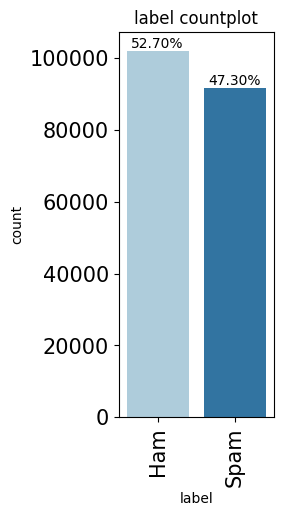

In [ ]:
labeled_barplot(df, 'label', perc=True)

- The dataset consists of 47.30% Spam mails and 52.70% Ham mails.

- ### Obtain sample of 50,000 while maintaining the slight imbalance in the dataset.

In [ ]:
#Group the DataFrame by category and get the count
category_counts = df.groupby('label').size()
category_counts

label
Ham     102160
Spam     91692
dtype: int64

In [ ]:
#define feature and target
feature = df['text']
target = df['label']
#performed stratified split the features with
x_train, _, y_train, _ = train_test_split(feature, target, stratify=target, train_size=50000, test_size=10000, random_state=100)
#join the feature and target
df1 = pd.concat([x_train, y_train], axis=1)
#reset the index
df1.reset_index(inplace=True, drop=True)
print(df1.shape)
df1.label.value_counts(normalize=True)

(50000, 2)


label
Ham     0.527
Spam    0.473
Name: proportion, dtype: float64

- This shows that the 50,000 sample of the dataset has been obtained while retaining the slight imbalance in the data.

In [ ]:
df1.isnull().sum()

text     0
label    0
dtype: int64

In [ ]:
df1.duplicated().sum()

0

In [ ]:
df1.to_csv('email_data_uncleaned.csv', index=False)

- There are neither duplicates nor missing values in the subset obtained.

# Explore the distribution of Special characters in Ham and Spam mails

In [ ]:
text = '[]$@@6'
x = '!@#$%^&*()'
count = 0
for i in x:
  if i in text:
    count+=1
count

2

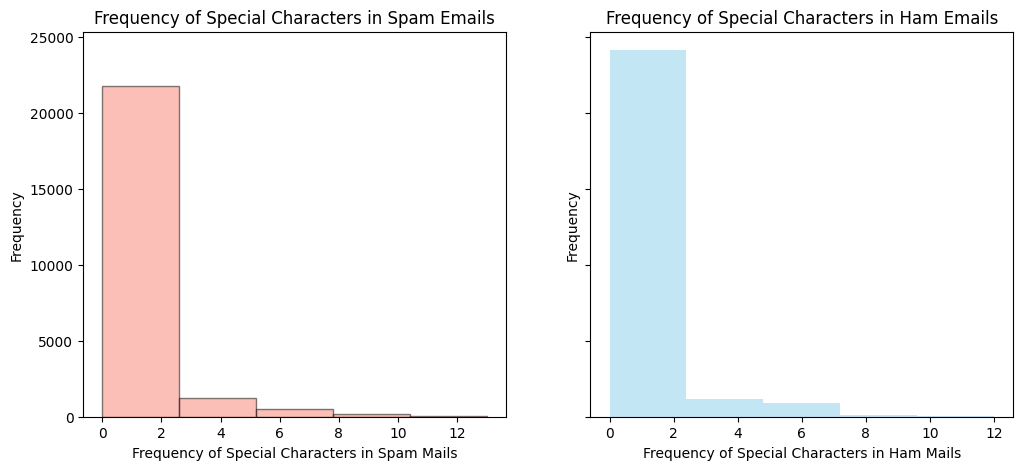

In [ ]:
# get the subset of the data for each category
spam_df = df1[df1['label'] == 'Spam']
ham_df = df1[df1['label'] == 'Ham']


# Plotting histograms of email lengths and word counts for spam and ham emails
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# define pattern
pattern = '!@#$%^&*()/?|\{}[]'
spam_special_chars_freq = []
ham_special_chars_freq = []

# Calculate frequency of special characters in spam and ham emails
#loop through the df
for i in range(spam_df.shape[0]):
  count = 0
  #for each text
  text = spam_df['text'].iloc[i]
  #if the special characters are in it
  for i in pattern:
    if i in text:
      #count increase by one
      count +=1
  spam_special_chars_freq.append(count)
#same thing for the ham category
for i in range(ham_df.shape[0]):
  count = 0
  text = ham_df['text'].iloc[i]
  for i in pattern:
    if i in text:
      count +=1
  ham_special_chars_freq.append(count)



# Plot histogram for spam
axs[0].hist(spam_special_chars_freq, bins=5, color='salmon', alpha=0.5, label='Spam',  edgecolor='black')
axs[0].set_xlabel('Frequency of Special Characters in Spam Mails') #set xlabel
axs[0].set_ylabel('Frequency')#label yaxis
axs[0].set_title('Frequency of Special Characters in Spam Emails')#set the title

axs[1].hist(ham_special_chars_freq, bins=5, color='skyblue', alpha=0.5, label='Ham')#plot histogram for ham
axs[1].set_xlabel('Frequency of Special Characters in Ham Mails')#set xlabke
axs[1].set_ylabel('Frequency')#set ylabel
axs[1].set_title('Frequency of Special Characters in Ham Emails')#set title
plt.show()

- This plot indicates that both spam and ham mails had a similar frequency distribution of special characters. However, ham mails had slighly higher frequency of special characters.

# Text Preprocessing

In [ ]:
df1.sample(5)

text  \
12600                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                   

- The following cleaning techniques will be implemented
  - Text lowercasing: To ensure uniformity across the texts
  - All unwanted characters and extra whitespaces will be removed
  - Punctuations will be removed
  - Stop words will be removed.

In [ ]:

def total_cleaner(data, feat):
    """
    this function applies all the necessary preprocessing steps to the data,
    args:
      data: dataframe
      feat: feature
    returns:
      a cleaned data with preprocessing steps applied
    """
    data[feat] = data[feat].apply(str.lower) #lowercase the texts
    print("Text completely lowercased")
    data[feat] = data[feat].apply(remove_punctuation)#remove punctuations
    print("Punctuations completely lowercased")
    data[feat] = data[feat].apply(text_cleaner)#remove any other unwanted characters and  #whitespaces
    print("Unwanted characters, trailing or leading whitespaces removed")
    data[feat] = data[feat].apply(stopword_remover)
    print("stopwords removed")
    return data

In [ ]:
df1 = total_cleaner(df1, 'text')

df1.sample(3)

Text completely lowercased
Punctuations completely lowercased
Unwanted characters, trailing or leading whitespaces removed
stopwords removed


,text,label
31364,things shop debbie batten duke energy ngl services phone escapenumber escapenumber escapenumber fax escapenumber escapenumber escapenumber,Ham
37678,el rentabilidad home contactar suscripci n colaboraciones mapa del sitio estimado sr sra soy luis soler de la puente director del nuevo peri dico rentabilidad nuestra aportaci n fundamental al panorama period stico es que en el rentabilidad hay anuncios publicitarios sino ofertas concretas nuestros lectores que le supongan un ahorro efectivo un beneficio extra rentabilidad sobre las opciones que existan en el mercado por esta raz n dirijo usted ofreci ndole la posibilidad de disfrutar de esta nueva opci n de publicar una oferta nuestros subscriptores de forma absolutamente gratuita el costo que le supondr la publicidad de pago puede invertirlo en una oferta que realmente merezca la pena de esta forma aumentar su presencia de marca captar nuevos clientes dar conocer productos art culos concretos en definitiva invertir realmente en sus clientes si est usted interesado en esta nueva v comercial desea realizar alguna sugerencia contacte con nosotros tambi n puede colaborar con nosotros comunic ndonos para publicar en el rentabilidad las novedades que se produzcan en su sector envi ndonos art culos sobre aspectos que considere interesantes quiera aportar los lectores colaboraciones si considera que ste correo puede ser interesante para otra persona conocida por usted puede enviarle esta informaci n pulsando este enlace bien darnos conocer sus clientes reenvi ndoles este correo atentamente luis soler director http www rentabilidad org este mensaje es spam ha rellenado el formulario de nuestra web de nuestros patrocinadores bien su correo ha sido obtenido de directorios p blicos impresos de p ginas web localizadas trav de b squedas muy acotadas tem ticamente en yahoo google etc nuestra intenci n es hacerle llegar noticias que pueden ser de su inter e informaci n de nuestros servicios si desea volver recibir mensajes solo tiene que comunicarlo excluir rentabilidad com gracias,Spam
49438,lowest rate us history sound let escapenumber lenders compete refinance home credit report needed good credit bad credit care best finance rate credit challenged best customer service lowest interest rates years save escapenumber escapenumber per month go link insta quote monthly savings calculation http zmedhh prescapenumberces net lowest asp way quickly easily lower monthly bill payments putting cash pocket pull cash refinance enjoy http ayl prescapenumberces net lowest asp tcescapenumber http b prescapenumberces net gone asp,Spam


## Display Top words associated with Spam and Ham mails

In [ ]:
df1.columns = ['Text', 'Labels']


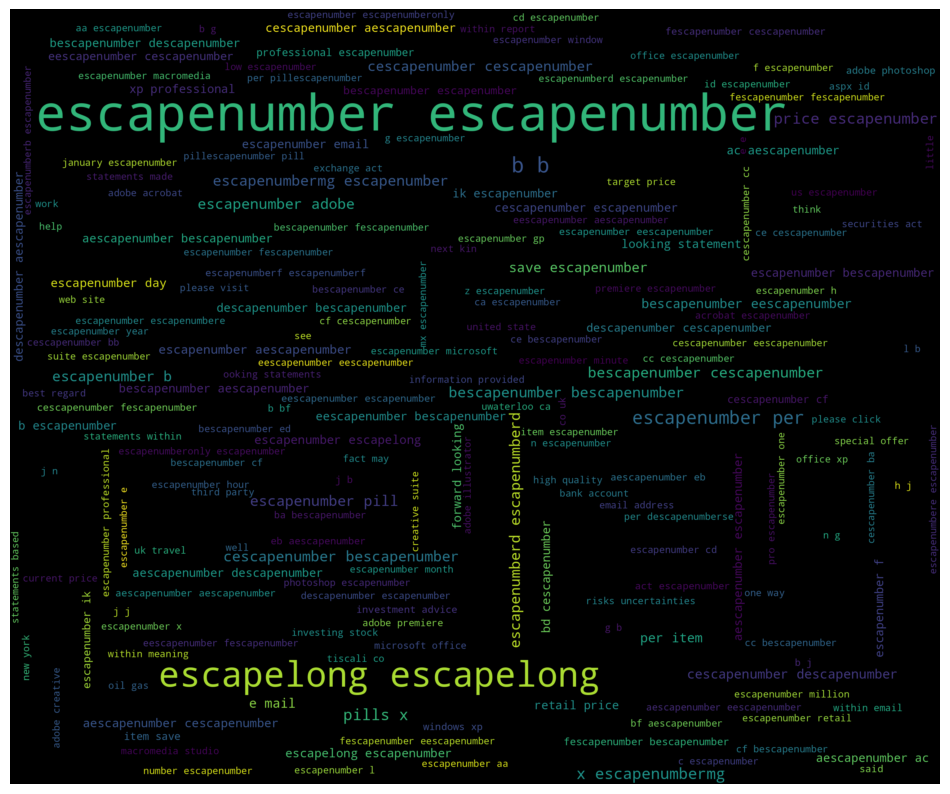

In [ ]:
WordCloudGen(df1, 'Spam')

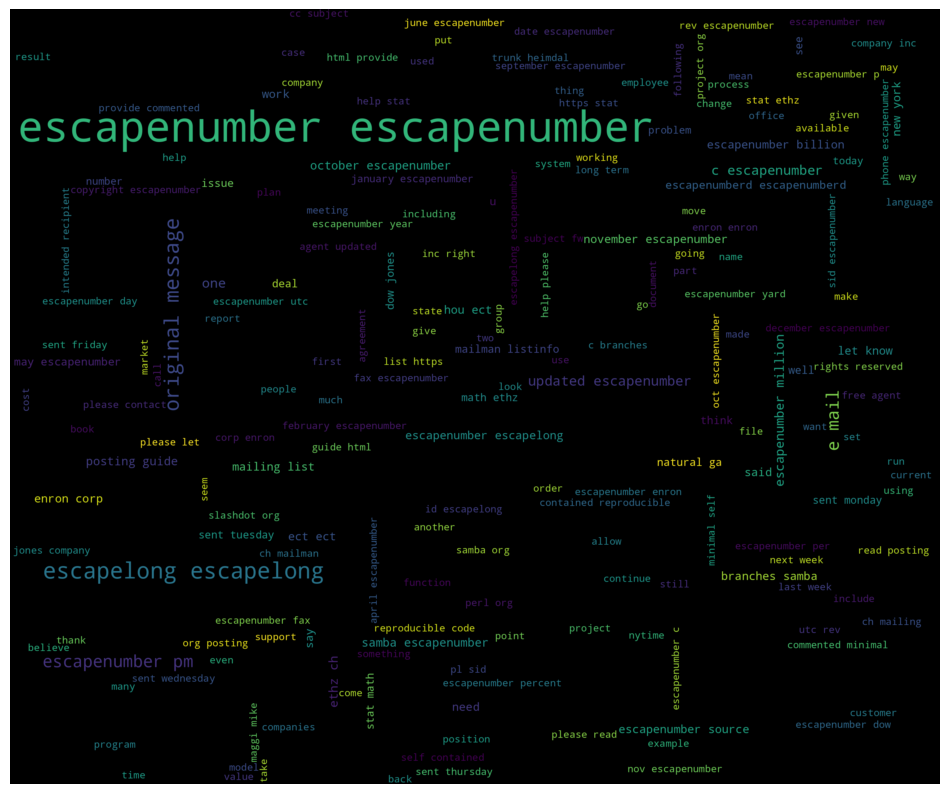

In [ ]:
WordCloudGen(df1, 'Ham')

- The plots above indicates that the terms "escapenumber" and variants of it are rampant in the dataset. Especially in the spam mails. Therefore, I will set this as a stopword to be removed.

In [ ]:
custom_stopwords = {'escapelong', 'escapenumber', 'bescapenumber', 'eescapenumber', 'cescapenumber', 'descapenumber',
                    'escapenumberd', 'escapenumberf', 'aescapenumber', 'escapenumbermg'}
STOPWORDS.update(custom_stopwords)

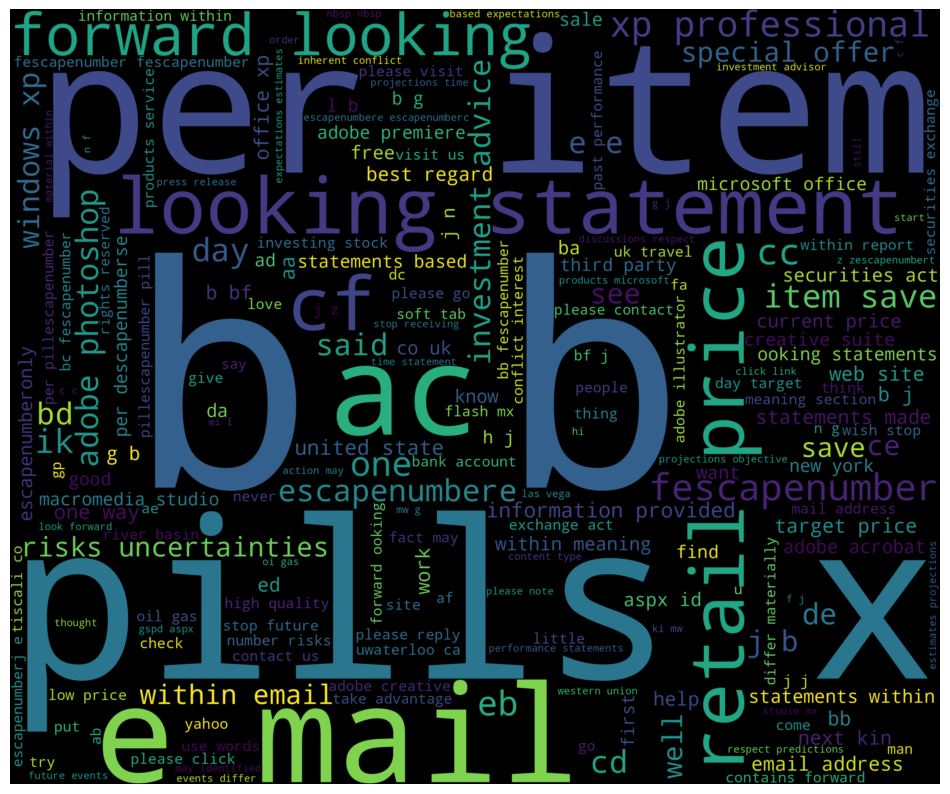

In [ ]:
WordCloudGen(df1, 'Spam')

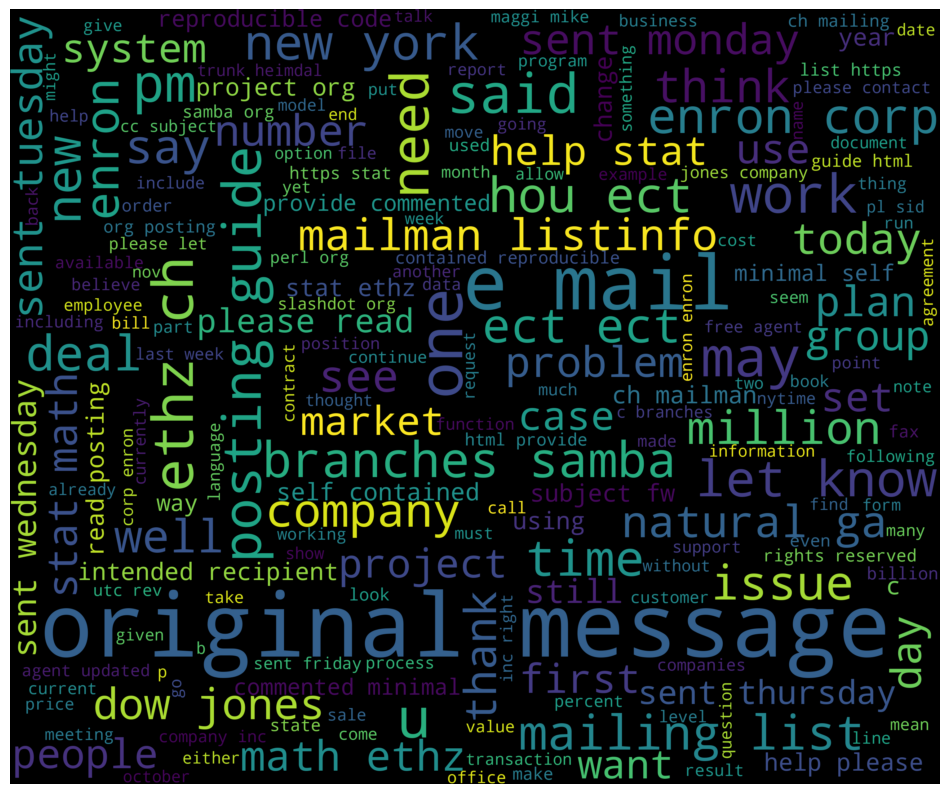

In [ ]:
WordCloudGen(df1, 'Ham')

# Remove the unwanted words from the text by updating the stopwords and process the text

In [ ]:
def stopword_remover(text):
    """
    the function removes stopwords found in the text and returns the remaining word
    text: string of words
    """
    # remove the word if the word is a stopword
    cleaned_tokens = [word for word in text.split() if word not in STOPWORDS]


    #join the remiaining words back together
    cleaned_text = " ".join(cleaned_tokens)

    # return the cleaned text
    return cleaned_text

In [ ]:
df1['Text'] = df1['Text'].apply(stopword_remover)

In [ ]:
df1.iloc[19210]

Text      original message swisher stephen sent tuesday november olsen michael subject fw centana storage importance high mike need deal entered sitra pathed sale centana storage aep see questions give call thanks stephen swisher specialist energy operations enron net works llc phone fax cell email stephen swisher enron original message wynne rita sent tuesday november pm pond jim cc koerselman lisa lo connie swisher stephen subject centana storage stephen please logistics deal entered pathed transaction questions please let know thanks original message pond jim sent tuesday november pm wynne rita cc koerselman lisa lo connie swisher stephen subject centana storage gl currently mmbtu believe sale took place facility original message wynne rita sent tuesday november pm pond jim cc koerselman lisa lo connie swisher stephen subject centana storage jim sale take place place sale facility stephen working reconciliation completed close unaccounted finishes reconciliation everything possible 

## Check for missing values again

In [ ]:
df1.isnull().sum()

Text      0
Labels    0
dtype: int64

In [ ]:
#check if any row is an empty string
df1['Text'].eq('').sum()


126

- this shows that some cells are empty strings

In [ ]:
df1[df1['Text'].eq('')].head()

,Text,Labels
81,,Ham
335,,Spam
896,,Spam
1127,,Spam
1243,,Spam


In [ ]:
ind = df1[df1['Text'].eq('')].index.tolist()

df1.drop(index=ind, inplace=True)
df1.reset_index(drop=True, inplace=True)

df1.shape

(49874, 2)

## Save the cleaned data

In [ ]:
df1.to_csv('cleaned_spam_detection_data.csv', index=False)

# Load the cleaned data

In [ ]:
data = file_reader('cleaned_spam_detection_data.csv')
data.head(1)

,Text,Labels
0,richard openings working town think position relo time appreciate referrals might home contact information know leaving building today thanks larry senior transportation storage analyst must possess minimum yrs related experience field depth understanding intricacies storage transportation gulf coast ne eastern canadian markets plus negotiate manage short long term natural gas storage transport transactions b develop hedging strategies forecast models provide trader support develop new business strategies conjunction risk management trading desks b supervise interstate regulatory issues pipelines storage providers c must confident communicator must able demonstrate high levels customer service maintaining profitability e must able analyze multiple factors influencing energy pricing capture opportunities locations f must team player individual drive g must detail oriented self starter requirements ba bs finance economics statistics related field strongly desired minimum years practical experience required ms office applications including word excel required director procurement position following responsibilities participate development implementation maintenance innovative electric natural gas service structures support gas electricity sourcing activities participate development implementation maintenance innovative electric natural gas service structures support gas electricity sourcing activities ability understand utilize electric natural gas pricing models utilize risk management techniques analyze energy product offerings minimize risk work closely eis rsg pq fsg sales groups groups assist design structure development retail electricity natural gas services possess detailed knowledge transportation pools tariffs ldc markets electric gas regulation activities marketing activities emerging power marketing activities develop manage sourcing deals coordinate closely product marketing group integrate energy management reliability information management solutions energy service offerings provide management support leadership team sourcing professionals position general manager level position ipp california calpine looking someone risk background come organization build team develop power options greater degree currently exists organization well funded good growth potential additional details follows develop risk management strategy system track manage risk evaluate assets power generation plants identify opportunities increase return assets company value profitability develop team sell new excess power capacity develop market intelligence system collect produce reports monthly basis,Ham


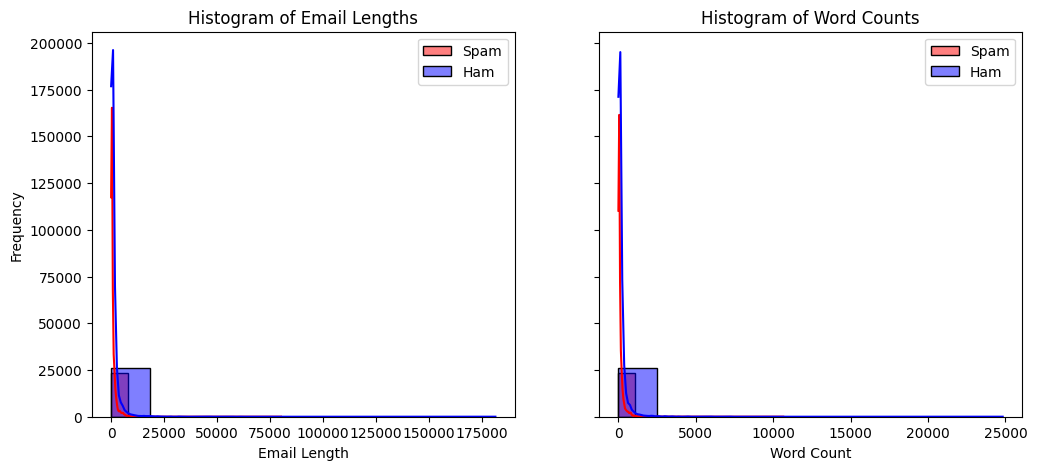

In [ ]:

import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# Sample DataFrame with 'text' and 'label' columns

df = data.copy()

# Compute email lengths and word counts for spam and ham emails
df['Email Length'] = df['Text'].apply(len)
df['Word Count'] = df['Text'].apply(lambda x: len(x.split()))

# Separate spam and ham emails
spam_df = df[df['Labels'] == 'Spam']
ham_df = df[df['Labels'] == 'Ham']

# Plotting histograms of email lengths and word counts for spam and ham emails
fig, axs = plt.subplots(1, 2, figsize=(12, 5), sharey=True)

# Email Lengths
sns.histplot(data=spam_df, x='Email Length', bins=10, color='red', alpha=0.5, label='Spam', kde=True, ax=axs[0])
sns.histplot(data=ham_df, x='Email Length', bins=10, color='blue', alpha=0.5, label='Ham', kde=True, ax=axs[0])
axs[0].set_title('Histogram of Email Lengths')
axs[0].set_xlabel('Email Length')
axs[0].set_xlabel('Email Length')
axs[0].set_ylabel('Frequency')
axs[0].legend()
# plt.xlim([0, 7000])

# Word Counts
sns.histplot(data=spam_df, x='Word Count', bins=10, color='red', alpha=0.5, label='Spam', kde=True, ax=axs[1])
sns.histplot(data=ham_df, x='Word Count', bins=10, color='blue', alpha=0.5, label='Ham', kde=True, ax=axs[1])
axs[1].set_title('Histogram of Word Counts')
axs[1].set_xlabel('Word Count')
axs[1].set_ylabel('Frequency')
axs[1].legend()




- This shows that Spam mails were generally shorter in Word count and length of characters they contain compared to Ham emails.
- This could be because they are generally targeted to deliver a short message in terms of campaign or trick the receipient to click a malicious link. To do this effectively, it is usually best to keep the email concise to deliver a point of action.

# Vectorization
- I will obtain 2 sparse vector represnetation of the data namely: Bag-of-words vectors and TF-IDF Vectors.
- I will also obtain 2 Dense vector represenation of the data: Continuous-Bag-of-words and Skipgram embeddings.

- These would be used as features during modeling and the performance of each models with the features will be noted.

# Sparse Features
### Bag of Words and TF-IDF  vectors

In [ ]:
# vectorize the reviews
def text_vectorizer(data, column, BOW=True, TFIDF=True, max_feat=1000):
    """
    returns bow and tfidt vectors of the texts
    if tfidf=False, only bow vectors will be returned with max_feat
    df : dataframe
    column: specified comment column name
    """
    BW = CountVectorizer(max_features=max_feat)
    bow_vectors = BW.fit_transform(data[column]).toarray()

    TF = TfidfVectorizer(max_features=max_feat)
    tf_vectors = TF.fit_transform(data[column]).toarray()

    if BOW == True and TFIDF != True:
        return bow_vectors

    elif BOW == True and TFIDF == True:
        return bow_vectors, tf_vectors, BW, TF

In [ ]:
bow_feat, tf_feat, BW, TF = text_vectorizer(data, 'Text')

In [ ]:
bow_feat

array([[0, 0, 1, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0]])

In [ ]:
tf_feat

array([[0.        , 0.        , 0.05390261, ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       ...,
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ],
       [0.        , 0.        , 0.        , ..., 0.        , 0.        ,
        0.        ]])

## Dense vectors
#### Continuous Bag of words

In [ ]:
def word_embeddings_getter(model, token_list):
    """
    this function returns an array of word-embedding vectors for each token found in the list of tokens
    model: model
    token_list: each itirative sentence in a list

    """
    embeddings = []
    vocab = set(model.wv.key_to_index) #get vocabulary

    for token in token_list: #for each  word in token_list
        if token in vocab: #if the token (word) is found in the vocab
            embeddings.append(model.wv.get_vector(token))#append the word embeddings to the list

    if len(embeddings) == 0: #if length of embdding is zero
        return np.zeros(model.vector_size) #retrun matrices of zeros with specifed dimension
    else:
        return(np.mean(embeddings, axis=0)) #return the mean of word embeddings for each word

def avg_word_emb(model, sentence):
    """
    this function applies the get_word_embeddings on each sentence
    model: model
    sentence: list containing a list of tokens
    """

    for token_list in sentence:

        word_embedding = [word_embeddings_getter(model, token_list) for token_list in sentence]
        #this will put every averaged word embedding for each sentence in a list hence we are able to retain the
        #shape of the array

        return np.array(word_embedding)

In [ ]:
#step1: import relevant packages
from gensim.models import Word2Vec

#step2: append all reviews in a list
mail_list = []
for reviews in data['Text']:
    tokens = reviews.split()
    mail_list.append(tokens)

#step3: define the word2vec model of 100-Dimension
amazon_w2v_model = Word2Vec(sentences=mail_list, min_count=5, vector_size=100)

In [ ]:
#save the word2vec model
amazon_w2v_model.save("/w2v_model.model")

In [ ]:
#step4: get the word embeddings
w2v_emb = avg_word_emb(model=amazon_w2v_model, sentence=mail_list)
#view the word embeddings
pd.DataFrame(w2v_emb)


,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.491774,0.634525,-0.214001,-0.190993,-0.283583,-0.572638,0.066266,-0.225981,1.532260,0.673073,...,-0.075410,0.203800,-0.809959,-0.054813,-0.159705,-0.439517,-0.256330,-0.141618,-0.493321,0.792891
1,-0.716429,0.445710,-0.106533,-0.231351,0.111299,-0.847031,0.397902,-0.197775,0.865538,0.606446,...,0.311779,-0.148554,-0.280423,0.339545,0.305492,0.016668,0.011957,-0.125153,-0.789255,0.863216
2,-0.487709,0.099461,0.324692,-0.646767,-0.134863,-0.655101,-0.203353,0.180643,0.602519,0.672120,...,0.347115,0.517693,0.128600,0.324762,0.145644,0.372143,-0.316980,-0.286515,-0.871181,0.267717
3,-0.287315,0.135243,-0.320351,0.847886,-0.547905,-0.828892,-0.913321,0.641892,0.673259,0.948574,...,0.423639,-0.466245,-0.149074,1.479422,-0.351777,0.459994,0.552261,0.192221,-0.021164,0.776218
4,-0.971762,-0.199710,0.574270,0.192953,0.730889,-1.824319,-0.331405,-0.068165,-0.256442,0.703713,...,0.533502,1.123029,1.005427,0.349495,0.947620,1.090245,0.437377,-0.146140,-0.351170,-0.082345
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
49869,-0.426208,-0.048636,0.056798,-0.210153,-0.154907,-0.067673,-0.379078,-0.036168,0.678240,0.254559,...,0.097401,-0.073164,-0.498578,0.345180,-0.158548,0.051002,-0.164389,-0.077022,-0.200677,0.369917
49870,-0.368587,-0.989182,0.213397,-0.146934,-0.093925,0.144496,0.034635,0.360728,0.380197,-0.020432,...,0.246679,0.292015,-0.151376,0.325066,0.077350,-0.171856,-0.501190,0.121824,0.171566,0.365830
49871,-0.275186,-0.738503,0.442669,0.047357,0.007306,0.165903,0.188294,0.858831,0.067851,-0.078530,...,0.462468,0.671934,0.156571,-0.036166,0.130772,-0.177107,-0.294650,0.322119,0.505770,0.288719
49872,0.123002,-0.967844,-0.169093,-0.470938,0.007592,-0.243689,-0.346807,-0.367790,0.740446,0.542936,...,0.666132,0.169134,-0.140156,0.288692,0.346990,0.241132,-0.355298,-0.044246,-0.010258,-0.122606


#### Skipgram embeddings

In [ ]:
#specifying 'sg=1' implement skipgram
skip_g = Word2Vec(sentences=mail_list, sg=1,vector_size=100)

In [ ]:
#get the word embeddings
sk_wb = avg_word_emb(model=skip_g, sentence=mail_list)

In [ ]:
pd.DataFrame(sk_wb).head() #displays the word embeddings for the first 5 rows

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,-0.181392,0.310365,-0.207935,-0.146323,-0.223076,-0.175665,-0.230329,0.006931,0.415595,-0.313863,...,-0.100172,-0.064470,-0.229093,0.109505,0.196677,0.035491,0.233232,0.033174,-0.053689,0.467111
1,-0.201003,0.277491,-0.235284,-0.165972,-0.035160,-0.215043,-0.195960,0.044930,0.247589,-0.134657,...,-0.025068,-0.315700,-0.104606,0.126358,0.252868,0.085810,0.323713,0.117014,-0.032387,0.508973
2,-0.024709,0.326342,-0.196284,-0.410861,-0.240699,-0.060209,-0.446243,0.047675,0.301683,-0.350481,...,0.062526,0.026868,0.103764,0.122120,0.360623,0.208619,0.215649,-0.122583,-0.115607,0.394349
3,0.190364,0.129330,-0.279802,0.124007,-0.273813,-0.365082,-0.843540,-0.006678,0.309220,-0.295864,...,0.304929,-0.231265,0.182818,0.306070,0.131208,0.136658,0.761981,0.090286,0.013980,0.535480
4,-0.303267,0.311184,-0.268995,-0.302938,-0.285037,-0.225487,-0.373730,0.128262,0.178739,-0.000598,...,0.058860,0.028525,-0.009305,-0.140560,0.412154,0.347288,0.434796,-0.117138,-0.134730,0.248768


# Encode the target

In [ ]:
from sklearn.preprocessing import LabelEncoder
#instantiate the encoder
le = LabelEncoder()
#encode the target
data['Labels'] = le.fit_transform(data['Labels'])

In [ ]:
data.head()

,Text,Labels
0,richard openings working town think position relo time appreciate referrals might home contact information know leaving building today thanks larry senior transportation storage analyst must possess minimum yrs related experience field depth understanding intricacies storage transportation gulf coast ne eastern canadian markets plus negotiate manage short long term natural gas storage transport transactions b develop hedging strategies forecast models provide trader support develop new business strategies conjunction risk management trading desks b supervise interstate regulatory issues pipelines storage providers c must confident communicator must able demonstrate high levels customer service maintaining profitability e must able analyze multiple factors influencing energy pricing capture opportunities locations f must team player individual drive g must detail oriented self starter requirements ba bs finance economics statistics related field strongly desired minimum years practical experience required ms office applications including word excel required director procurement position following responsibilities participate development implementation maintenance innovative electric natural gas service structures support gas electricity sourcing activities participate development implementation maintenance innovative electric natural gas service structures support gas electricity sourcing activities ability understand utilize electric natural gas pricing models utilize risk management techniques analyze energy product offerings minimize risk work closely eis rsg pq fsg sales groups groups assist design structure development retail electricity natural gas services possess detailed knowledge transportation pools tariffs ldc markets electric gas regulation activities marketing activities emerging power marketing activities develop manage sourcing deals coordinate closely product marketing group integrate energy management reliability information management solutions energy service offerings provide management support leadership team sourcing professionals position general manager level position ipp california calpine looking someone risk background come organization build team develop power options greater degree currently exists organization well funded good growth potential additional details follows develop risk management strategy system track manage risk evaluate assets power generation plants identify opportunities increase return assets company value profitability develop team sell new excess power capacity develop market intelligence system collect produce reports monthly basis,0
1,dear sirs aegis capital group llc aegis specialty investment firm managing private equity venture capital funds national focus small businesses social benefits supporting entrepreneurs enhancing local job creation stress company pays special attention customer support private customers though corresponding business plans bigger companies well detailed information company may obtain official website due necessity expansion company announced additional openings new employees glad offer one vacant positions company team position account manager responsibility following duties fulfillment orders given company operations bank transfers direct deposits wires customers implementation calculations regarding customer payments acceleration space needed delivery payments regional branches provision money transactions customers payments via worldwide western union instant transfer system procession correspondence means mail forwarding scanning position offered regarded part time job need free hour day able work us earn net commission every transaction dealt traveling expenses transfer fee charges covered customer need previous experience finance sphere provide detailed instructions support advice stage responsibilities implementation may hope career growth within company certain circumstances chance providing services major companies vip cust

- spam mail: 1
- Ham mail: 0

# Split the data

In [ ]:
#define features for BOW
X = bow_feat
#define target
y = data['Labels']

#split into BOW train set(80%), validation set and test set (10% each)
x_train_b, x_V, y_train_b, y_V = train_test_split(X, y, train_size=0.8, random_state=10, stratify=y)
x_val_b, x_test_b, y_val_b, y_test_b = train_test_split(x_V, y_V, train_size=0.5, random_state=10, stratify=y_V)


In [ ]:
#define features for TF-IDF
X = tf_feat
#define target
y = data['Labels']

#split into TF-IDF train set(80%), validation set and test set (10% each)
x_train_idf, x_V, y_train_idf, y_V = train_test_split(X, y, train_size=0.8, random_state=10, stratify=y)
x_val_idf, x_test_idf, y_val_idf, y_test_idf = train_test_split(x_V, y_V, train_size=0.5, random_state=10, stratify=y_V)


In [ ]:
X = w2v_emb
y = data['Labels']

#split the cbow features into train, validation and test set(80:10:10)
x_train_cbow, x_V, y_train_cbow, y_V = train_test_split(X, y, train_size=0.8, random_state=100, stratify=y)
x_val_cbow, x_test_cbow, y_val_cbow, y_test_cbow = train_test_split(x_V, y_V, train_size=0.5, random_state=100, stratify=y_V)

In [ ]:
X = sk_wb
y = data['Labels']

#split the skipgram features into train, validation and test set(80:10:10)
x_train_sg, x_V, y_train_sg, y_V = train_test_split(X, y, train_size=0.8, random_state=100, stratify=y)
x_val_sg, x_test_sg, y_val_sg, y_test_sg = train_test_split(x_V, y_V, train_size=0.5, random_state=100, stratify=y_V)

## Modeling

In [ ]:
def model_trainer(algorithm, X, y):
    """
    trains the model with given parameters
    algorithm: algorithm
    X: x_train scaled
    y = target
    """
    trained_model = algorithm.fit(X, y) #train the algorithm

    prediction = trained_model.predict(X)  #making prediction on the train data

    acc = accuracy_score(y, prediction)  #make predictions
    #print(f"train accuracy : {acc}")  #print accuracy
    print("train accuracy : {:.3f}".format(acc))
    return trained_model   #return trained model

def perf_evaluator(model, x_test, y_test):
    #make predicition
    y_pred = model.predict(x_test)
    #print classification report
    print(classification_report(y_test, y_pred))

    #obtain a confusion matrix
    conf = confusion_matrix(y_test, y_pred)
    confds = ConfusionMatrixDisplay(conf, display_labels=['Ham', 'Spam'])
    confds.plot()

def train_and_evaluate(algo, x_train, y_train, x_val, y_val):
    """
    trains a model, test on the val set and returns the classification report
    """
    model = model_trainer(algo, x_train, y_train)
    performance = perf_evaluator(model, x_val, y_val)

    return model


## Decision Tree Model using the BOW features

train accuracy : 0.830
              precision    recall  f1-score   support

           0       0.90      0.76      0.83      2634
           1       0.77      0.91      0.84      2353

    accuracy                           0.83      4987
   macro avg       0.84      0.84      0.83      4987
weighted avg       0.84      0.83      0.83      4987



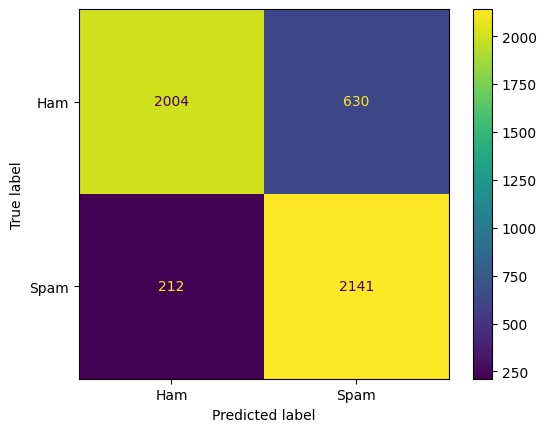

In [ ]:
d_tree = DecisionTreeClassifier(max_depth=6)

#decision tree model performance on the bow vectors
d_tree_bow = train_and_evaluate(d_tree, x_train_b, y_train_b, x_val_b, y_val_b)

- using the Bag-of-words features, the decision tree model classified more Ham mails to be spam (precisley 628 of them.)

- 90% of model's prediction for Ham mails were correct. However, only 76% of the ham mails in the dataset were correctly identified as Ham mails.

- In contrast, 91% of spam mails in the data were rightly identifed as such by the model. However, only 77% of the mails predicted to be spam were correct.

- The f1 score for spam classification was 84%

## Decision Tree Model using the tf-idf features



train accuracy : 0.831
              precision    recall  f1-score   support

           0       0.90      0.76      0.82      2634
           1       0.77      0.91      0.83      2353

    accuracy                           0.83      4987
   macro avg       0.84      0.83      0.83      4987
weighted avg       0.84      0.83      0.83      4987



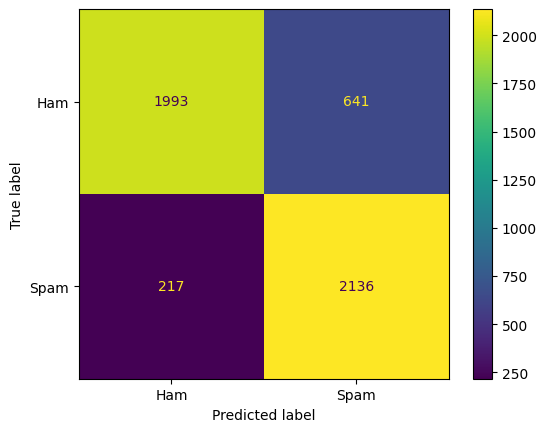

In [ ]:
d_tree = DecisionTreeClassifier(max_depth=6)

#decision tree model performance on the bow vectors
d_tree_bow = train_and_evaluate(d_tree, x_train_idf, y_train_idf, x_val_idf, y_val_idf)

- In general, the performance of the model was the same when bow features was used.
- But closely looking at the number of True positives, True negatives, False positive and false negatives, the decision tree performed better when the bow features were used because lesser number of false predictions was obtained.

## Decision Tree Model using the CBOW features

train accuracy : 0.920
              precision    recall  f1-score   support

           0       0.91      0.92      0.91      2634
           1       0.91      0.89      0.90      2353

    accuracy                           0.91      4987
   macro avg       0.91      0.91      0.91      4987
weighted avg       0.91      0.91      0.91      4987



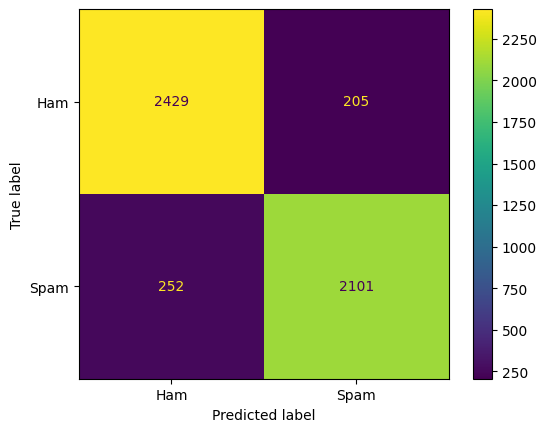

In [ ]:
d_tree = DecisionTreeClassifier(max_depth=6)

#decision tree model performance on the bow vectors
d_tree_bow = train_and_evaluate(d_tree, x_train_cbow, y_train_cbow, x_val_cbow, y_val_cbow)

- using the CBOW Dense features, the decision tree model performed better compared to the sparse features.

- 91% of model's prediction for Ham mails were correct. However, only 92% of the ham mails in the dataset were correctly identified as Ham mails.

- In contrast, 89% of spam mails in the data were rightly identifed as such by the model. However, only 91% of the mails predicted to be spam were correct.

- The f1 score for spam classification was 90%

## Decision Tree Model using the Skipgram features

train accuracy : 0.910
              precision    recall  f1-score   support

           0       0.90      0.91      0.90      2634
           1       0.89      0.89      0.89      2353

    accuracy                           0.90      4987
   macro avg       0.90      0.90      0.90      4987
weighted avg       0.90      0.90      0.90      4987



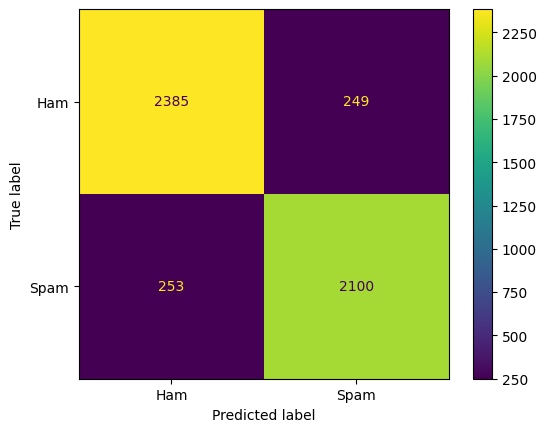

In [ ]:
d_tree = DecisionTreeClassifier(max_depth=6)

#decision tree model performance on the bow vectors
d_tree_bow = train_and_evaluate(d_tree, x_train_sg, y_train_sg, x_val_sg, y_val_sg)

- In general, the decision tree model performed better when dense features were used compared to the sparse features.

- 90% of model's prediction for Ham mails were correct. However, only 91% of the ham mails in the dataset were correctly identified as Ham mails.

- In contrast, 89% of spam mails in the data were rightly identifed as such by the model. However, only 89% of the mails predicted to be spam were correct.

- The f1 score for spam classification was 89%

#### Fitting the Decision tree algorithm on the CBOW embeddings gave the best performance.

## Ensemble Model (Gradient Boosting) on CBOW features




In [ ]:
from sklearn.ensemble import GradientBoostingClassifier

train accuracy : 0.956
              precision    recall  f1-score   support

           0       0.95      0.95      0.95      2634
           1       0.94      0.95      0.95      2353

    accuracy                           0.95      4987
   macro avg       0.95      0.95      0.95      4987
weighted avg       0.95      0.95      0.95      4987



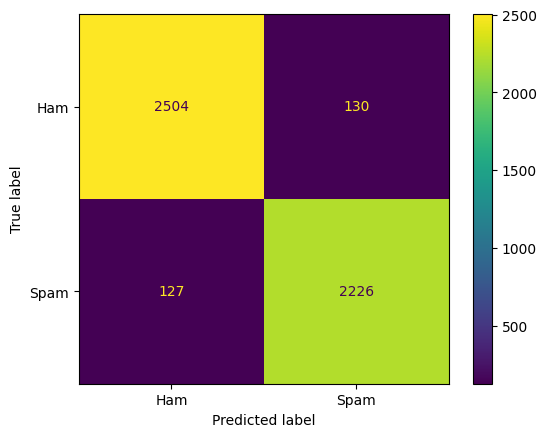

In [ ]:
gb = GradientBoostingClassifier(random_state=0)


#GadientBoosting model performance on the cbow vectors
gb_model = train_and_evaluate(gb, x_train_cbow, y_train_cbow, x_val_cbow, y_val_cbow)

- using the CBOW Dense features, the Gradientboosting model performed better compared to the DecisionTree model.

- 95% of model's prediction for Ham mails were correct. However, only 95% of the ham mails in the dataset were correctly identified as Ham mails.

- In contrast, 95% of spam mails in the data were rightly identifed as such by the model. However, only 94% of the mails predicted to be spam were correct.

## Ensemble Model (Gradient Boosting) on Skipgram features

train accuracy : 0.961
              precision    recall  f1-score   support

           0       0.96      0.95      0.96      2634
           1       0.95      0.95      0.95      2353

    accuracy                           0.95      4987
   macro avg       0.95      0.95      0.95      4987
weighted avg       0.95      0.95      0.95      4987



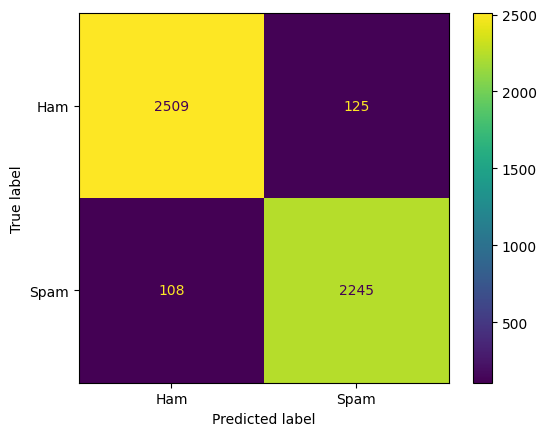

In [ ]:
gb = GradientBoostingClassifier(random_state=0)


#GadientBoosting model performance on the cbow vectors
gb_model_sg = train_and_evaluate(gb, x_train_sg, y_train_sg, x_val_sg, y_val_sg)

- Relative to using the cbow embeddings, the Gradientboosting model performed better when fitted on the skipgram Dense features.

- 96% of model's prediction for Ham mails were correct. However, only 95% of the ham mails in the dataset were correctly identified as Ham mails.

- In contrast, 95% of spam mails in the data were rightly identifed as such by the model. However, only 95% of the mails predicted to be spam were correct.

- The f1 score for spam classification was 95%

## Ensemble Model (Gradient Boosting) on Bag-Of-Words features


train accuracy : 0.906
              precision    recall  f1-score   support

           0       0.95      0.86      0.91      2634
           1       0.86      0.95      0.90      2353

    accuracy                           0.90      4987
   macro avg       0.91      0.91      0.90      4987
weighted avg       0.91      0.90      0.90      4987



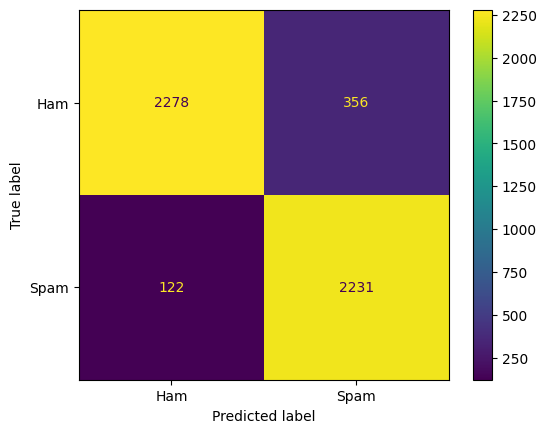

In [ ]:
gb = GradientBoostingClassifier(random_state=0)

#decision tree model performance on the bow vectors
gb_model = train_and_evaluate(gb, x_train_b, y_train_b, x_val_b, y_val_b)

- This indicates that the ensemble model did not perform better when fitted on the sparse vectors.

## Performance Evaluation of Best performing Traditional Model on the Test set

              precision    recall  f1-score   support

           0       0.96      0.95      0.96      2635
           1       0.94      0.96      0.95      2353

    accuracy                           0.95      4988
   macro avg       0.95      0.96      0.95      4988
weighted avg       0.95      0.95      0.95      4988



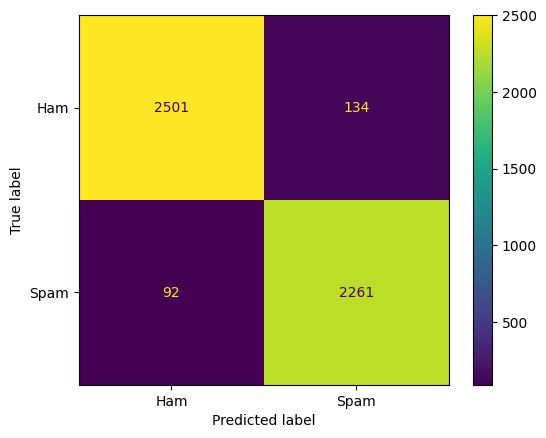

In [ ]:
perf_evaluator(gb_model_sg, x_test_sg, y_test_sg)

- A simiar performance was observed on the test data. This indicates that the model generalizes well.

# Hyperparameter Tuning

In [ ]:
#import gridsearch for hyperparameter tuning
from sklearn.model_selection import GridSearchCV
#instantiate the bes classifier
gb = GradientBoostingClassifier()
#define parameter scope
param = {'loss' : ['log_loss', 'exponential'],
         'max_depth': [3, 4]}
#instantiate the gridsearch
gs = GridSearchCV(gb, param, scoring='recall', cv=2, n_jobs=-1)
X = sk_wb #feature
y = data['Labels'] #target
#fit the gridsearch algorithm
gs_m = gs.fit(X, y)

In [ ]:
best_params = gs_m.best_params_

In [ ]:
gs_m.best_score_

0.9594966411966868

train accuracy : 0.972
              precision    recall  f1-score   support

           0       0.97      0.96      0.96      2634
           1       0.95      0.96      0.96      2353

    accuracy                           0.96      4987
   macro avg       0.96      0.96      0.96      4987
weighted avg       0.96      0.96      0.96      4987



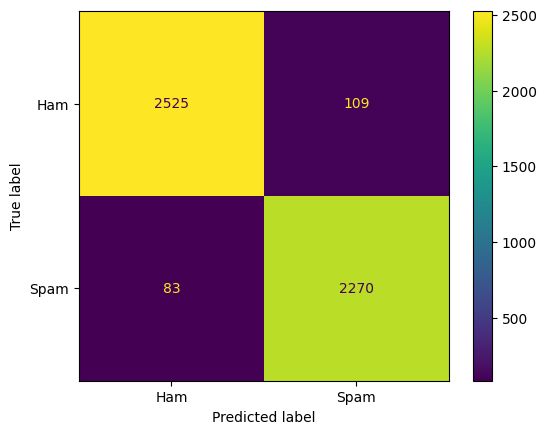

In [ ]:
#instantiate the algorithm with the best set of hyper-parameters
gb_best = GradientBoostingClassifier(**best_params)

gb_model_sg = train_and_evaluate(gb_best, x_train_sg, y_train_sg, x_val_sg, y_val_sg)

- So far, this combination of hyper-parameters gave the best performance.

- 97% of model's prediction for Ham mails were correct. However, only 96% of the ham mails in the dataset were correctly identified as Ham mails.

- In contrast, 96% of spam mails in the data were rightly identifed as such by the model. However, only 95% of the mails predicted to be spam were correct.

- The f1 score for spam classification was 96%

# Recurrent Neural Network

### Tokenize the text

In [ ]:
#initialize the tokenizer
tokenizer = Tokenizer(num_words=2000)

#fit on data to update vocabulary
tokenizer.fit_on_texts(data['Text'].values)

#convert text to sequence of integers
X_ve = tokenizer.texts_to_sequences(data['Text'].values)



In [ ]:

str_length = []
#for each row in the data
for i in range(len(data['Text'].values)):
  #append the length of each string to the list
  str_length.append(len(data['Text'][i].split()))

#convert the list to a series
length_df = pd.Series(str_length)
#give a descriptive stats of it
print(length_df.describe(percentiles=[0.75,0.95,0.99]))

count    49874.000000
mean       161.549625
std        404.413719
min          1.000000
50%         75.000000
75%        166.000000
95%        553.000000
99%       1326.540000
max      24821.000000
dtype: float64


- 99% of the text in the data are at most 1,327 charcters long.
- The longest text is 24,821 characters in length. Therefor I will pad the sequence to 500 to avoid sparisty issues.

In [ ]:
from sklearn.preprocessing import LabelEncoder
#instantiate the encoder
le = LabelEncoder()
#encode the target
data['Labels'] = le.fit_transform(data['Labels'])

In [ ]:
#to ensure consistency in length
X = pad_sequences(X_ve, maxlen=500)
y = data['Labels']



In [ ]:
#split the data
x_train, x_Ve, y_train, y_Ve = train_test_split(X, y, random_state=0,stratify=y,
                                                   test_size=0.2)
x_val, x_test, y_val, y_test = train_test_split(x_Ve, y_Ve, random_state=0,stratify=y_Ve,
                                                   test_size=0.5)


In [ ]:
#categorize the label
y_train_c = to_categorical(y_train)
y_test_c = to_categorical(y_test)
y_val_c = to_categorical(y_val)

In [ ]:
import tensorflow as tf
#define metrics
indices = [

       tf.keras.metrics.CategoricalAccuracy(name='accuracy'),
       tf.keras.metrics.Precision(name='precision'),
       tf.keras.metrics.Recall(name='recall'),
       tf.keras.metrics.AUC(name='auc')
]

# define early stopping layer
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

#define modelcheckpoint to save best model
path = '/checkpoint'

# define early stopping layer
es = EarlyStopping(monitor='val_recall', mode='max', verbose=2, patience=5)

#define modelcheckpoint to save best model
rnn_mc = ModelCheckpoint(filepath = path, save_best_only=True, monitor='val_recall', mode='max')


In [ ]:
#clear backend
from tensorflow.keras import backend
backend.clear_session()

In [ ]:
def RNN_model(embedding_dims=100, hidden_dims=32):
    model = Sequential()

    #obtain dense vectors of 100D
    model.add(Embedding(2000, output_dim=embedding_dims,input_length=x_train.shape[1]))
    #apply dropout
    model.add(SpatialDropout1D(0.2))
    #add a vanilla rnn for recurrent operation
    model.add(SimpleRNN(units=hidden_dims))
    #add a dense layer for further representation
    model.add(Dense(units=16, activation='relu'))
    #add a dense layer for classification
    model.add(Dense(y_train.nunique(), activation ='sigmoid'))

    #compile the network
    model.compile(optimizer='adam', metrics=indices, loss='binary_crossentropy')

    return model

In [ ]:
rnn = RNN_model()

rnn.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 100)          200000    
                                                                 
 spatial_dropout1d (Spatial  (None, 500, 100)          0         
 Dropout1D)                                                      
                                                                 
 simple_rnn (SimpleRNN)      (None, 32)                4256      
                                                                 
 dense (Dense)               (None, 16)                528       
                                                                 
 dense_1 (Dense)             (None, 2)                 34        
                                                                 
Total params: 204818 (800.07 KB)
Trainable params: 204818 (800.07 KB)
Non-trainable params: 0 (0.00 Byte)
________________

In [ ]:
#train the network
history = rnn.fit(x_train, y_train_c, batch_size=64,
        validation_split=0.2, epochs=30, callbacks=[es, rnn_mc])

Epoch 1/30
499/499 [==============================] - 103s 201ms/step - loss: 0.2593 - accuracy: 0.8868 - precision: 0.9173 - recall: 0.8334 - auc: 0.9575 - val_loss: 0.1327 - val_accuracy: 0.9560 - val_precision: 0.9738 - val_recall: 0.8886 - val_auc: 0.9863
Epoch 2/30
499/499 [==============================] - 90s 180ms/step - loss: 0.1010 - accuracy: 0.9647 - precision: 0.9731 - recall: 0.9481 - auc: 0.9924 - val_loss: 0.1226 - val_accuracy: 0.9594 - val_precision: 0.9676 - val_recall: 0.9424 - val_auc: 0.9892
Epoch 3/30
499/499 [==============================] - 91s 182ms/step - loss: 0.0679 - accuracy: 0.9778 - precision: 0.9844 - recall: 0.9627 - auc: 0.9963 - val_loss: 0.1326 - val_accuracy: 0.9620 - val_precision: 0.9679 - val_recall: 0.9494 - val_auc: 0.9889
Epoch 4/30
499/499 [==============================] - 89s 178ms/step - loss: 0.0414 - accuracy: 0.9872 - precision: 0.9912 - recall: 0.9768 - auc: 0.9985 - val_loss: 0.1432 - val_accuracy: 0.9618 - val_precision: 0.9689 - 

In [ ]:
#check the performance on the validation set
#get the predicted category
pred = np.argmax(rnn.predict(x_val), axis=1)

156/156 [==============================] - 4s 28ms/step


              precision    recall  f1-score   support

           0       0.95      0.94      0.95      2634
           1       0.94      0.95      0.94      2353

    accuracy                           0.95      4987
   macro avg       0.94      0.95      0.94      4987
weighted avg       0.95      0.95      0.95      4987



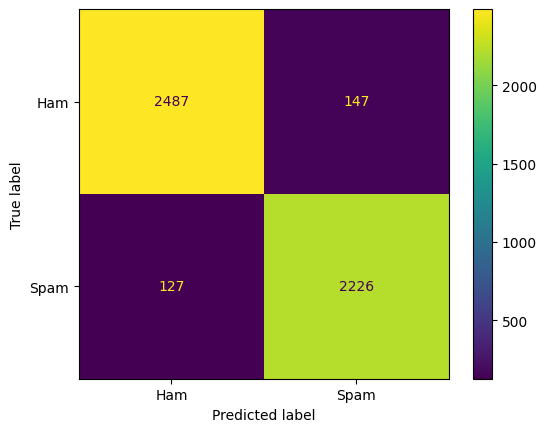

In [ ]:
print(classification_report(y_val, pred))

#obtain a confusion matrix
conf = confusion_matrix(y_val, pred)
confds = ConfusionMatrixDisplay(conf, display_labels=['Ham', 'Spam'])
confds.plot()

- Prior to hyperparameter tuning, the performance of the Recurrent Neural network was lower than that of the GradientBoosting model.

In [ ]:
rnn.evaluate(x_test, y_test_c)

156/156 [==============================] - 12s 74ms/step - loss: 0.2257 - accuracy: 0.9471 - precision: 0.9567 - recall: 0.9346 - auc: 0.9814


[0.22572584450244904,
 0.9470729827880859,
 0.9567002058029175,
 0.9346431493759155,
 0.9814462661743164]

In [ ]:
def view_perf(history):
  """
  plots the accuracy, val_accuracy and recall_score against epochs
  """
  #define accuracy
  acc = history.history['accuracy']

  #define validation_accuracy
  val_acc = history.history['val_accuracy']

  #specify epochs
  epochs = range(1, len(acc) + 1)

  plt.figure(figsize= (5,5)) #set figure size
  plt.plot(epochs, acc, label="Train Accuracy") #plot accuracy against epochs
  plt.plot(epochs, val_acc, label="validation Accuracy") #plot val_acc against epcohs
  plt.xlabel("Epochs")
  plt.ylabel("Categorical Accuracy Score")

  plt.legend(loc='best') #display the legends at the best location in the chart

  plt.show()#show the plot

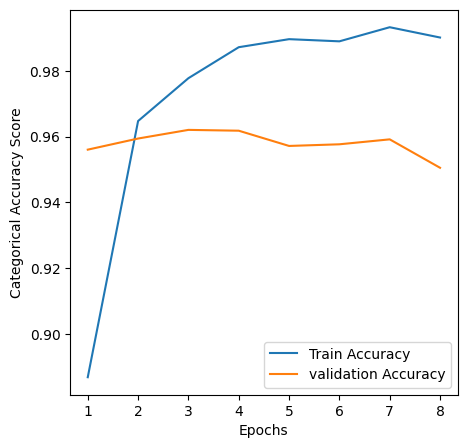

In [ ]:
view_perf(history)

- However, The training accuracy of the model was about 0.99.

# LSTM

In [ ]:
#clear backend
from tensorflow.keras import backend
backend.clear_session()

In [ ]:
def lstm(embedding_dims=100, hidden_dims=32):
  """
  returns a compiled lstm architecture
  embedding_dims : the desired shape of embeddings  30
  hidden_dims: number of neurons
  """
  #define structure to be a linear stack of layers
  model = Sequential()

  #add an ebedding layer to obtain dense representation of text sequence
  model.add(Embedding(2000, output_dim=embedding_dims,input_length= x_train.shape[1]))

  #add an LSTM layer
  model.add(LSTM(units=hidden_dims))

  #add a dense layer for further representation
  model.add(Dense(units=32, activation='relu'))

  #add a dense layer for further representation
  model.add(Dense(units=16, activation='relu'))
  model.add(Dropout(0.2))
  #add a dense
  model.add(Dense(y_train.nunique(), activation ='sigmoid'))

  model.compile(optimizer='adam', metrics=indices, loss='categorical_crossentropy')

  return model

In [ ]:
# define early stopping layer
es = EarlyStopping(monitor='val_recall', mode='max', verbose=2, patience=3)

# #define modelcheckpoint to save best model
path = '/lstm_models'
lstm_mc = ModelCheckpoint(filepath = path, save_best_only=True, monitor='val_recall', mode='max')


In [ ]:
lstm_1 = lstm()

lstm_1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 100)          200000    
                                                                 
 lstm (LSTM)                 (None, 32)                17024     
                                                                 
 dense (Dense)               (None, 32)                1056      
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dropout (Dropout)           (None, 16)                0         
                                                                 
 dense_2 (Dense)             (None, 2)                 34        
                                                                 
Total params: 218642 (854.07 KB)
Trainable params: 21864

In [ ]:
#train the network
lstm_history = lstm_1.fit(x_train, y_train_c, batch_size=32,
        validation_split=0.2, epochs=15, callbacks=[es, lstm_mc])

Epoch 1/15
998/998 [==============================] - 154s 153ms/step - loss: 0.1800 - accuracy: 0.9390 - precision: 0.9564 - recall: 0.8761 - auc: 0.9765 - val_loss: 0.1154 - val_accuracy: 0.9622 - val_precision: 0.9694 - val_recall: 0.9496 - val_auc: 0.9907
Epoch 2/15
998/998 [==============================] - 154s 155ms/step - loss: 0.0956 - accuracy: 0.9678 - precision: 0.9719 - recall: 0.9411 - auc: 0.9905 - val_loss: 0.1072 - val_accuracy: 0.9647 - val_precision: 0.9684 - val_recall: 0.9613 - val_auc: 0.9932
Epoch 3/15
998/998 [==============================] - 163s 163ms/step - loss: 0.0718 - accuracy: 0.9757 - precision: 0.9780 - recall: 0.9490 - auc: 0.9942 - val_loss: 0.1024 - val_accuracy: 0.9674 - val_precision: 0.9711 - val_recall: 0.9614 - val_auc: 0.9932
Epoch 4/15
998/998 [==============================] - 153s 154ms/step - loss: 0.0538 - accuracy: 0.9815 - precision: 0.9830 - recall: 0.9659 - auc: 0.9966 - val_loss: 0.0991 - val_accuracy: 0.9690 - val_precision: 0.9732

In [ ]:
#get the predictions on the validation set
pred = np.argmax(lstm_1.predict(x_val), axis=1)

156/156 [==============================] - 5s 27ms/step


              precision    recall  f1-score   support

           0       0.97      0.96      0.96      2634
           1       0.95      0.97      0.96      2353

    accuracy                           0.96      4987
   macro avg       0.96      0.96      0.96      4987
weighted avg       0.96      0.96      0.96      4987



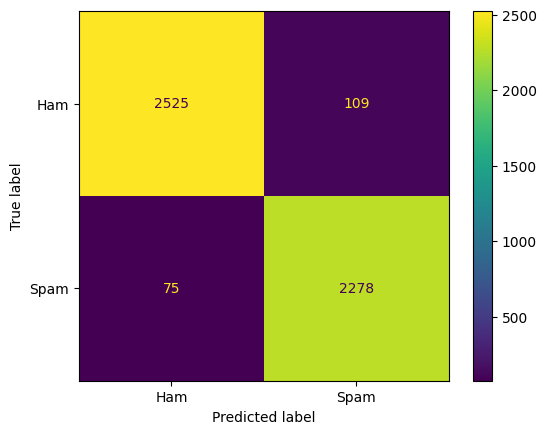

In [ ]:
print(classification_report(y_val, pred))

#obtain a confusion matrix
conf = confusion_matrix(y_val, pred)
confds = ConfusionMatrixDisplay(conf, display_labels=['Ham', 'Spam'])
confds.plot()

- The LSTM model performed closely to the best Gradient Boosting model.
- 97% of model's prediction for Ham mails were correct. However, only 95% of the ham mails in the dataset were correctly identified as Ham mails.

- In contrast, 97% of spam mails in the data were rightly identifed as such by the model. However, only 95% of the mails predicted to be spam were correct.

In [ ]:
lstm_1.evaluate(x_test, y_test_c)

156/156 [==============================] - 4s 28ms/step - loss: 0.2221 - accuracy: 0.9619 - precision: 0.9632 - recall: 0.9611 - auc: 0.9881


[0.22206513583660126,
 0.9619085788726807,
 0.9632308483123779,
 0.9611066579818726,
 0.9881359338760376]

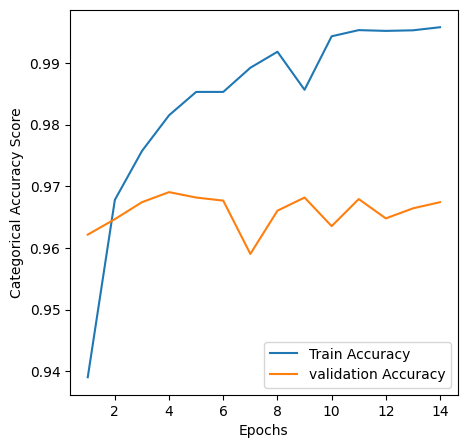

In [ ]:
view_perf(lstm_history)

## Modifying the LSTM network

In [ ]:
#clear backend
from tensorflow.keras import backend
backend.clear_session()

In [ ]:
def lstm2(embedding_dims=100, hidden_dims=64):
  """
  returns a compiled lstm architecture
  embedding_dims : the desired shape of embeddings  30
  hidden_dims: number of neurons
  """
  #define structure to be a linear stack of layers
  model = Sequential()

  #add an ebedding layer to obtain dense representation of text sequence
  model.add(Embedding(2000, output_dim=embedding_dims,input_length= x_train.shape[1]))

  #add an LSTM layer
  model.add(LSTM(units=hidden_dims))

  #add a dense layer for further representation
  model.add(Dense(units=32, activation='relu'))

  #add a dropout layer
  model.add(Dropout(0.3))

  #add a dense layer for further representation
  model.add(Dense(units=16, activation='relu'))
  #add a dense
  model.add(Dense(y_train.nunique(), activation ='sigmoid'))

  model.compile(optimizer='adam', metrics=indices, loss='categorical_crossentropy')

  return model

In [ ]:
lstm_2 = lstm2()

lstm_2.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 100)          200000    
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 32)                2080      
                                                                 
 dropout (Dropout)           (None, 32)                0         
                                                                 
 dense_1 (Dense)             (None, 16)                528       
                                                                 
 dense_2 (Dense)             (None, 2)                 34        
                                                                 
Total params: 244882 (956.57 KB)
Trainable params: 24488

In [ ]:
# define early stopping layer
es = EarlyStopping(monitor='val_recall', mode='max', verbose=2, patience=3)

# #define modelcheckpoint to save best model
path = '/lstm2_models'
lstm2_mc = ModelCheckpoint(filepath = path, save_best_only=True, monitor='val_recall', mode='max')


In [ ]:
#train the network
lstm_history = lstm_2.fit(x_train, y_train_c, batch_size=64,
        validation_split=0.2, epochs=15, callbacks=[es, lstm2_mc])

Epoch 1/15
499/499 [==============================] - 212s 422ms/step - loss: 0.1995 - accuracy: 0.9347 - precision: 0.9230 - recall: 0.9448 - auc: 0.9755 - val_loss: 0.1292 - val_accuracy: 0.9556 - val_precision: 0.9526 - val_recall: 0.9591 - val_auc: 0.9884
Epoch 2/15
499/499 [==============================] - 210s 421ms/step - loss: 0.1090 - accuracy: 0.9633 - precision: 0.9608 - recall: 0.9656 - auc: 0.9914 - val_loss: 0.1082 - val_accuracy: 0.9630 - val_precision: 0.9622 - val_recall: 0.9642 - val_auc: 0.9919
Epoch 3/15
499/499 [==============================] - 205s 410ms/step - loss: 0.0822 - accuracy: 0.9725 - precision: 0.9710 - recall: 0.9741 - auc: 0.9949 - val_loss: 0.1014 - val_accuracy: 0.9670 - val_precision: 0.9650 - val_recall: 0.9685 - val_auc: 0.9931
Epoch 4/15
499/499 [==============================] - 210s 421ms/step - loss: 0.0686 - accuracy: 0.9771 - precision: 0.9756 - recall: 0.9784 - auc: 0.9965 - val_loss: 0.1459 - val_accuracy: 0.9533 - val_precision: 0.9485

In [ ]:
#get the predictions on the validation set
pred = np.argmax(lstm_2.predict(x_val), axis=1)

156/156 [==============================] - 8s 49ms/step


              precision    recall  f1-score   support

           0       0.97      0.96      0.96      2634
           1       0.95      0.97      0.96      2353

    accuracy                           0.96      4987
   macro avg       0.96      0.96      0.96      4987
weighted avg       0.96      0.96      0.96      4987



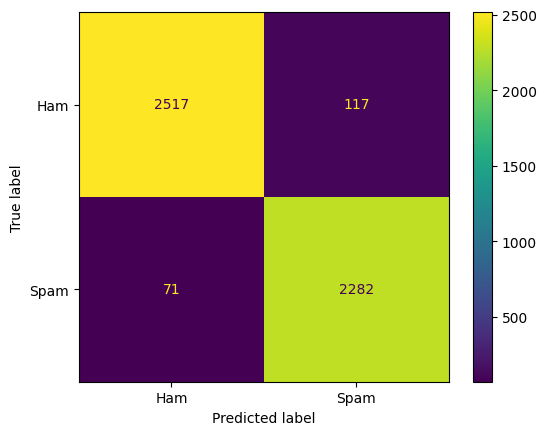

In [ ]:
print(classification_report(y_val, pred))

#obtain a confusion matrix
conf = confusion_matrix(y_val, pred)
confds = ConfusionMatrixDisplay(conf, display_labels=['Ham', 'Spam'])
confds.plot()

- This version of the LSTM had false positives.

- 96% of model's prediction for Ham mails were correct. However, only 97% of the ham mails in the dataset were correctly identified as Ham mails.

- In contrast, 97% of spam mails in the data were rightly identifed as such by the model. However, only 95% of the mails predicted to be spam were correct.

- The f1 score for spam classification was 96%

In [ ]:
lstm_2.evaluate(x_test, y_test_c)

156/156 [==============================] - 12s 78ms/step - loss: 0.1626 - accuracy: 0.9601 - precision: 0.9601 - recall: 0.9601 - auc: 0.9851


[0.16261112689971924,
 0.96010422706604,
 0.96010422706604,
 0.96010422706604,
 0.9850987792015076]

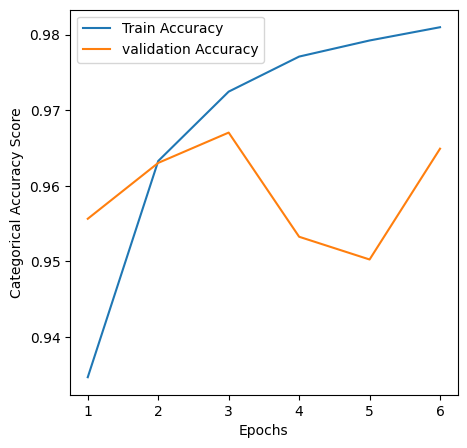

In [ ]:
view_perf(lstm_history)

## Hyper-parameter Tuning

In [ ]:
!pip install keras-tuner

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 129.1/129.1 kB 1.4 MB/s eta 0:00:00


In [ ]:
from kerastuner.tuners import RandomSearch, Hyperband

<ipython-input-63-e64760501d7e>:1: DeprecationWarning: `import kerastuner` is deprecated, please use `import keras_tuner`.
  from kerastuner.tuners import RandomSearch, Hyperband


## Build the architecture for hyperparameter optimization

In [ ]:
#clear backend
from tensorflow.keras import backend
backend.clear_session()

In [ ]:
def build_model(hp,
    embedding_dims=100, hidden_dims=64):
  """
  returns a compiled lstm architecture
  embedding_dims : the desired shape of embeddings  30
  hidden_dims: number of neurons
  """
  #define structure to be a linear stack of layers
  model = Sequential()

  out_dim = hp.Choice('output_dim', values=[100, 200])
  #add an ebedding layer to obtain dense representation of text sequence
  model.add(Embedding(2000, output_dim=out_dim, input_length= x_train.shape[1]))

  hidden_dim = hp.Int('units', min_value=32, max_value=64, step=32)
  #add an LSTM layer
  model.add(LSTM(units=hidden_dims))

  hidden_dim2 = hp.Int('units', min_value=32, max_value=64, step=32)

  #add a dense layer for further representation
  model.add(Dense(units=hidden_dim2, activation='relu'))

  #add a dropout layer
  model.add(Dropout(0.3))

  #add a dense layer for further representation
  model.add(Dense(units=hidden_dim2, activation='relu'))
  #add a dense
  model.add(Dense(y_train.nunique(), activation ='sigmoid'))

  model.compile(optimizer='adam', metrics=indices, loss='binary_crossentropy')

  return model

In [ ]:
from kerastuner import Objective
tuner = RandomSearch(build_model,
                     objective=Objective('val_recall',direction="max"),
                     max_trials=2,
                     executions_per_trial=2,
                     project_name='spam_email_detector')

Reloading Tuner from ./spam_email_detector/tuner0.json


In [ ]:
tuner.search(x_train, y_train_c, batch_size=64,
        validation_data=(x_val, y_val_c), epochs=2, callbacks=[es])

In [ ]:
best_params = tuner.get_best_hyperparameters()[0]


In [ ]:
best_params

## Rebuild the network with best hyper-parameters

In [ ]:
h_model = tuner.hypermodel.build(best_params)
h_model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding (Embedding)       (None, 500, 100)          200000    
                                                                 
 lstm (LSTM)                 (None, 64)                42240     
                                                                 
 dense (Dense)               (None, 96)                6240      
                                                                 
 dropout (Dropout)           (None, 96)                0         
                                                                 
 dense_1 (Dense)             (None, 96)                9312      
                                                                 
 dense_2 (Dense)             (None, 2)                 194       
                                                                 
Total params: 257986 (1007.76 KB)
Trainable params: 2579

In [ ]:
history_tuned = h_model.fit(x_train, y_train_c, batch_size=64,
        validation_split=0.2, epochs=15, callbacks=[es])

Epoch 1/15
499/499 [==============================] - 209s 415ms/step - loss: 0.1880 - accuracy: 0.9353 - precision: 0.9356 - recall: 0.9343 - auc: 0.9813 - val_loss: 0.1190 - val_accuracy: 0.9586 - val_precision: 0.9584 - val_recall: 0.9589 - val_auc: 0.9904
Epoch 2/15
499/499 [==============================] - 200s 400ms/step - loss: 0.1044 - accuracy: 0.9649 - precision: 0.9650 - recall: 0.9649 - auc: 0.9922 - val_loss: 0.1083 - val_accuracy: 0.9603 - val_precision: 0.9602 - val_recall: 0.9605 - val_auc: 0.9920
Epoch 3/15
499/499 [==============================] - 199s 398ms/step - loss: 0.0781 - accuracy: 0.9736 - precision: 0.9739 - recall: 0.9735 - auc: 0.9954 - val_loss: 0.1040 - val_accuracy: 0.9652 - val_precision: 0.9655 - val_recall: 0.9650 - val_auc: 0.9920
Epoch 4/15
499/499 [==============================] - 200s 400ms/step - loss: 0.0629 - accuracy: 0.9787 - precision: 0.9788 - recall: 0.9788 - auc: 0.9967 - val_loss: 0.1113 - val_accuracy: 0.9637 - val_precision: 0.9637

In [ ]:
#get the predictions on the validation set using the hyper Model
pred = np.argmax(h_model.predict(x_val), axis=1)

156/156 [==============================] - 7s 45ms/step


              precision    recall  f1-score   support

           0       0.96      0.96      0.96      2634
           1       0.95      0.96      0.96      2353

    accuracy                           0.96      4987
   macro avg       0.96      0.96      0.96      4987
weighted avg       0.96      0.96      0.96      4987



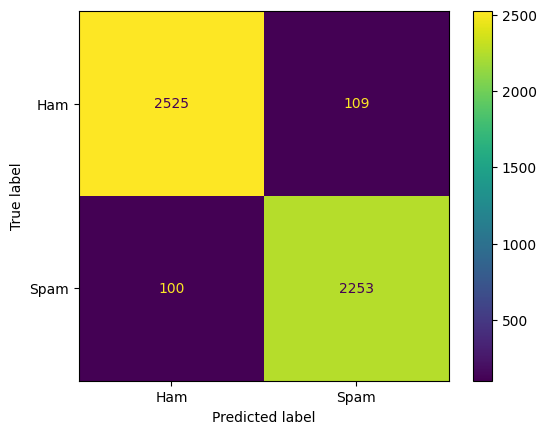

In [ ]:
print(classification_report(y_val, pred))

#obtain a confusion matrix
conf = confusion_matrix(y_val, pred)
confds = ConfusionMatrixDisplay(conf, display_labels=['Ham', 'Spam'])
confds.plot()

- The LSTM model with set of tuned hyperparameters did not out perform the initial LSTM model.
- 96% of model's prediction for Ham mails were correct. However, only 96% of the ham mails in the dataset were correctly identified as Ham mails.

- In contrast, 96% of spam mails in the data were rightly identifed as such by the model. However, only 95% of the mails predicted to be spam were correct.

- The f1 score for spam classification was 96%

In [ ]:
h_model.evaluate(x_test, y_test_c)

156/156 [==============================] - 14s 92ms/step - loss: 0.1556 - accuracy: 0.9599 - precision: 0.9597 - recall: 0.9599 - auc: 0.9861


[0.1556161791086197,
 0.9599037766456604,
 0.9597113728523254,
 0.9599037766456604,
 0.9861057996749878]

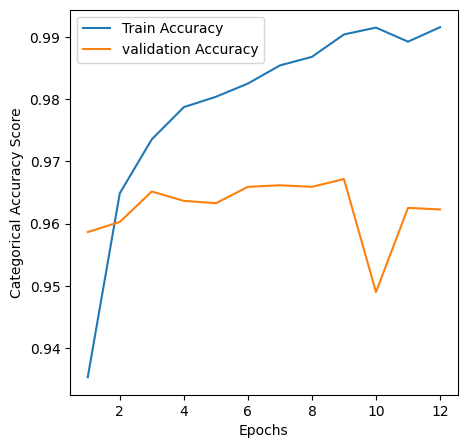

In [ ]:
view_perf(history_tuned)

# BERT using Simple Transformers

In [ ]:
!pip install simpletransformers

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 315.5/315.5 kB 5.8 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 510.5/510.5 kB 12.1 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 43.6/43.6 kB 6.0 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 101.7/101.7 kB 13.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 18.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 8.1/8.1 MB 40.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.3/207.3 kB 26.9 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 267.1/267.1 kB 22.3 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 116.3/116.3 kB 11.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 194.1/194.1 kB 24.6 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 134.8/134.8 kB 16.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 4.8/4.8 MB 5

In [ ]:
data = file_reader('cleaned_spam_detection_data.csv')
data.head(1)

,Text,Labels
0,richard openings working town think position relo time appreciate referrals might home contact information know leaving building today thanks larry senior transportation storage analyst must possess minimum yrs related experience field depth understanding intricacies storage transportation gulf coast ne eastern canadian markets plus negotiate manage short long term natural gas storage transport transactions b develop hedging strategies forecast models provide trader support develop new business strategies conjunction risk management trading desks b supervise interstate regulatory issues pipelines storage providers c must confident communicator must able demonstrate high levels customer service maintaining profitability e must able analyze multiple factors influencing energy pricing capture opportunities locations f must team player individual drive g must detail oriented self starter requirements ba bs finance economics statistics related field strongly desired minimum years practical experience required ms office applications including word excel required director procurement position following responsibilities participate development implementation maintenance innovative electric natural gas service structures support gas electricity sourcing activities participate development implementation maintenance innovative electric natural gas service structures support gas electricity sourcing activities ability understand utilize electric natural gas pricing models utilize risk management techniques analyze energy product offerings minimize risk work closely eis rsg pq fsg sales groups groups assist design structure development retail electricity natural gas services possess detailed knowledge transportation pools tariffs ldc markets electric gas regulation activities marketing activities emerging power marketing activities develop manage sourcing deals coordinate closely product marketing group integrate energy management reliability information management solutions energy service offerings provide management support leadership team sourcing professionals position general manager level position ipp california calpine looking someone risk background come organization build team develop power options greater degree currently exists organization well funded good growth potential additional details follows develop risk management strategy system track manage risk evaluate assets power generation plants identify opportunities increase return assets company value profitability develop team sell new excess power capacity develop market intelligence system collect produce reports monthly basis,Ham


# Encode the target

In [ ]:
from sklearn.preprocessing import LabelEncoder
#instantiate the encoder
le = LabelEncoder()
#encode the target
data['Labels'] = le.fit_transform(data['Labels'])

In [ ]:
import pandas as pd
import numpy as np
from sklearn.metrics import f1_score
from sklearn.metrics import classification_report
from datasets import load_dataset
from simpletransformers.classification import ClassificationModel, ClassificationArgs
from sklearn.model_selection import train_test_split

In [ ]:
data["Labels"].value_counts(normalize = True)

Labels
0    0.528231
1    0.471769
Name: proportion, dtype: float64

## **Data Preparation**

In [ ]:
# rename the columns
data.rename(columns = {"Text": "text", "Labels": "labels"}, inplace = True)

# Split the data
X = data["text"]
y = data["labels"]
x_train, x_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)


# Concatenate features with targets
train_set = pd.concat([x_train, y_train], axis=1)
test_set = pd.concat([x_test, y_test], axis=1)

# reset the index
train_set.reset_index(drop = True, inplace = True)
test_set.reset_index(drop = True, inplace = True)

### **Model Training**

In [ ]:
# Optional model configuration
model_args = ClassificationArgs(num_train_epochs=1)

# Create a ClassificationModel
model = ClassificationModel(
    'bert',
    'bert-base-uncased',
    num_labels=2,
    args=model_args,
    use_cuda = True
)

# Train the model
print("==========================Training a BERT Model=================================")
model.train_model(train_set)

Some weights of BertForSequenceClassification were not initialized from the model checkpoint at bert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


==========================Training a BERT Model=================================


  0%|          | 0/79 [00:00<?, ?it/s]

Epoch:   0%|          | 0/1 [00:00<?, ?it/s]

Running Epoch 1 of 1:   0%|          | 0/4988 [00:00<?, ?it/s]

(4988, 0.15793006100204757)

In [ ]:
# Evaluate the model
result, model_outputs, wrong_predictions = model.eval_model(test_set)

  0%|          | 0/19 [00:00<?, ?it/s]

Running Evaluation:   0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
result

{'mcc': 0.9560648465315766,
 'accuracy': 0.9780451127819549,
 'f1_score': 0.9765046668812359,
 'tp': 4551,
 'tn': 5205,
 'fp': 64,
 'fn': 155,
 'auroc': 0.9977137967166687,
 'auprc': 0.9973278371718888,
 'eval_loss': 0.09809995418589096}

In [ ]:
len(wrong_predictions)

219

In [ ]:
test_set.reset_index(drop = True, inplace = True)

In [ ]:
test_mails = []
for i in range(test_set.shape[0]):
    tweet = test_set["text"][i]
    test_mails.append(tweet)

In [ ]:
# Make predictions with the model
predictions, raw_outputs = model.predict(test_mails)

  0%|          | 0/19 [00:00<?, ?it/s]

  0%|          | 0/100 [00:00<?, ?it/s]

In [ ]:
from sklearn.metrics import classification_report

In [ ]:
# compute classification report
cls_report = classification_report(test_set["labels"],
                                   predictions,
                                   target_names = ["Ham", "Spam"])

print(f"Classification Report: \n {cls_report}")

Classification Report: 
               precision    recall  f1-score   support

         Ham       0.97      0.99      0.98      5269
        Spam       0.99      0.97      0.98      4706

    accuracy                           0.98      9975
   macro avg       0.98      0.98      0.98      9975
weighted avg       0.98      0.98      0.98      9975



- This is the best performance thus far.

- 97% of model's prediction for Ham mails were correct. However, only 99% of the ham mails in the dataset were correctly identified as Ham mails.

- In contrast, 97% of spam mails in the data were rightly identifed as such by the model. However, only 99% of the mails predicted to be spam were correct.
- The f1 score was 0.98

# FLAN-T5

In [ ]:
# !pip install datasets
# !ip install transformers[torch]
# !pip install tokenizers
# !pip install evaluate
# !pip install sentencepiece
# !pip install huggingface_hub
# !pip install peft

In [ ]:
import nltk
# import evaluate
import numpy as np
from transformers import T5Tokenizer, DataCollatorForSeq2Seq
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM
from transformers import T5ForConditionalGeneration, Seq2SeqTrainingArguments, Seq2SeqTrainer
# from peft import LoraConfig, get_peft_model, TaskType

## Connect to Huggingface

In [ ]:
from huggingface_hub import notebook_login

notebook_login()

In [ ]:
# !pip install langchain

In [ ]:
from langchain.prompts.few_shot import FewShotPromptTemplate
from langchain.prompts.prompt import PromptTemplate
from langchain.chains import LLMChain

## Load the data

In [ ]:
data = file_reader('email_data_uncleaned.csv')

## Download the FLAN-T5 model and tokenizer

In [ ]:
# # Load the tokenizer, model, and data collator
# MODEL_NAME = "google/flan-t5-base"
# #load the tokenizer
# tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME)
# #load the model
# model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME)
# data_collator = DataCollatorForSeq2Seq(tokenizer=tokenizer, model=model)

## Save the model and tokenizer to local path

In [ ]:
# output_dir = "./saved_model/"
# tokenizer.save_pretrained(output_dir)
# model.save_pretrained(output_dir)

## Load the model and tokenizer from local path

In [ ]:
output_dir_model = "/content/drive/MyDrive/large_FLAN_T5"
output_dir_tok = "/content/drive/MyDrive/large_FLAN_T5_Tokenizer"
#load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(output_dir_tok)
#load the model
model = AutoModelForSeq2SeqLM.from_pretrained(output_dir_model)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.


In [ ]:
output_dir = "./saved_model/"
#load the tokenizer
tokenizer = AutoTokenizer.from_pretrained(output_dir)
#load the model
model = AutoModelForSeq2SeqLM.from_pretrained(output_dir)

Special tokens have been added in the vocabulary, make sure the associated word embeddings are fine-tuned or trained.
You set `add_prefix_space`. The tokenizer needs to be converted from the slow tokenizers


In [ ]:
data.columns

Index(['text', 'label'], dtype='object')

In [ ]:
# !pip install simpletransformers

In [ ]:
import pandas as pd
# from simpletransformers.t5 import T5Model
from sklearn.model_selection import train_test_split


data = file_reader('email_data_uncleaned.csv')


# rename the columns
#data.rename(columns = {"Labels": "target_text"}, inplace = True)


# Split the data
X = data["text"]
y = data["label"]
x_train, x_test, y_train, y_test = train_test_split(X, y, train_size=100, test_size=100, stratify=y, random_state=42)


# Concatenate features with targets
train_set = pd.concat([x_train, y_train], axis=1)
test_set = pd.concat([x_test, y_test], axis=1)

# reset the index
train_set.reset_index(drop = True, inplace = True)
test_set.reset_index(drop = True, inplace = True)


In [ ]:
# model.to('cuda')

In [ ]:
test_set.sample(2)

,text,label
62,a straight prompt way to lose pounds isnt a tale but reality therma cuts the most effectual way is lose weight naturally it is absolutely new natural herbal cure that allows you to diminish food craving on the basis of this revolutionary remedy you don't need to exhaust yourself with doubtful diet programs and waste your spare time jogging thanks to new we've managed to create a pill combining unequalled natural properties medicinal features and inferences of multiaspect scientific inquiry one more weighty preference of therma cuts is that there are no side effects in it futher it aids you to make better your health and rejuvenize your organism fill your life with colours of mirth http healthmodern com,Spam
91,w quail golf since escapenumber spring sale click home page click hot products http www dwquailgolf com online golfers shop us quality price delivery thousands golf products pay early spring time start training golf season also time offer lowest prices best golf training items seen golf channel want see sneak preview items buy right sale seen click http www dwquailgolf com training htm ball spinner sweet spot finder secret pros revealed sale stock ships day hottest product escapenumber click see http www dwquailgolf com training ball spinner html david leadbetters lazerguide seen golf channel sale stock ships day free shipping check low price click see http www dwquailgolf com training lazerguide html kallassys swing magic seen tv sale stock ships day check sale item click see http www dwquailgolf com training htm zen oracle putting trainer seen tv sale stock ships day everyone talking click see http www dwquailgolf com training zen oracle html swing wave swing trainer one best new products escapenumber sale stock ships day swing training strength one click see http www dwquailgolf com training htm golf speed swing meter best price youve ever seen sale stock ships day measures swing speed click see http www dwquailgolf com training golf speed html freddy connect dual trace seen golf channel sale stock ships day cure hook slice click see http www dwquailgolf com training freddyconnect html balance bracelets seen golf channel used copper magnetics want somethig really works sale stock ships day click see http www dwquailgolf com jewelry htm quick links great golf items training aids click http www dwquailgolf com training htm accessories click http www dwquailgolf com access htm country club leather click http www dwquailgolf com countryclubleather html burton golf bags click http www dwquailgolf com bags htm new product arrivals http www dwquailgolf com animal headcovers click http www dwquailgolf com animal headcovers html pro line golf ball click http www dwquailgolf com training proline html aimum ball marking tool click http www dwquailgolf com training aimum html simple spin putting tool click http www dwquailgolf com training simplespin html putting laser click http www dwquailgolf com training redline html golf specs putt glasses click http www dwquailgolf com training golfspec html putting dragon click http www dwquailgolf com training puttingdragon html caddy stick putter prop click http www dwquailgolf com caddystick html bandit wedge see click http www dwquailgolf com clubs banditwedge html chip golf target game click http www dwquailgolf com training chipit html swing n view mirrors http www dwquailgolf com training swing view mirror html company newsletter list many ways get list one way get want please email us golftraining usanetaccess net tell us remove established business online escapenumber year sometimes competiors put peoples address sign forms happen please email us ill take thanks enjoy gollf season david,Spam


In [ ]:
# get the number of samples
samples_number = len(train_set)
#empty list to store predictions
predictions_list = []
# labels_list = []

for i in range(samples_number):
#for each text in the train_set
  text = train_set['text'][i]
  #pass the text to a prompt
  prompt = f"""
    You are to classify an email: {text} as either 'Spam' or 'Ham'
    Spam: A email that contains unsolicited offers and requests personal information or unsercured links example http:.
    Ham: A email that  contains a legitimate message and does not contain spam.
    Your response should be either spam or ham
  """
  #encode the prompts
  inputs = tokenizer.encode_plus(prompt, padding='max_length', max_length=512, return_tensors='pt').to('cuda')
  #get model prediction
  outputs = model.generate(inputs['input_ids'], attention_mask=inputs['attention_mask'], max_length=150, num_beams=4, early_stopping=True)
  #decode model output
  prediction = tokenizer.decode(outputs[0], skip_special_tokens=True)
  #append prediction to list
  predictions_list.append(prediction)


In [ ]:
#predictions_list
y_pred = []
for i in range(len(predictions_list)):
  if predictions_list[i].lower() == 'ham':
    y_pred.append('Ham')
  else:
    y_pred.append('Spam')

In [ ]:
y_true = train_set['label'].values

In [ ]:
from sklearn.metrics import classification_report

report = classification_report(y_true, y_pred)
print(report)

              precision    recall  f1-score   support

         Ham       0.55      0.57      0.56        53
        Spam       0.49      0.47      0.48        47

    accuracy                           0.52       100
   macro avg       0.52      0.52      0.52       100
weighted avg       0.52      0.52      0.52       100




- 55% of model's prediction for Ham mails were correct. However, only 57% of the ham mails in the dataset were correctly identified as Ham mails.

- In contrast, 47% of spam mails in the data were rightly identifed as such by the model. However, only 49% of the mails predicted to be spam were correct.
- The f1 score for spam predictions was 0.48

# Result Summary

### Summary of the results from Decision Tree Model

In [ ]:
import pandas as pd
import numpy as np
columns= ['Feature', 'Class Label', 'Precision', 'Recall', 'F1 Score']
pd.DataFrame(columns=columns, data=np.array([['BOW', 'Ham', 0.90, 0.76, 0.83], [' ', 'Spam', 0.77, 0.91, 0.84],
                                             ['TF-IDF', 'Ham', 0.90, 0.76, 0.82], [' ', 'Spam', 0.77, 0.91, 0.83],
                                             ['CBOW', 'Ham', 0.91, 0.92, 0.91], [' ', 'Spam', 0.91, 0.89, 0.90],
                                             ['Skipgram', 'Ham', 0.90, 0.91, 0.90], [' ', 'Spam', 0.89, 0.89, 0.89]]))

,Feature,Class Label,Precision,Recall,F1 Score
0,BOW,Ham,0.9,0.76,0.83
1,,Spam,0.77,0.91,0.84
2,TF-IDF,Ham,0.9,0.76,0.82
3,,Spam,0.77,0.91,0.83
4,CBOW,Ham,0.91,0.92,0.91
5,,Spam,0.91,0.89,0.9
6,Skipgram,Ham,0.9,0.91,0.9
7,,Spam,0.89,0.89,0.89


### Summary of the results from Gradient Boosting Model


In [ ]:
import pandas as pd
import numpy as np
columns= ['Feature', 'Class Label', 'Precision', 'Recall', 'F1 Score']
pd.DataFrame(columns=columns, data=np.array([['BOW', 'Ham', 0.95, 0.86, 0.91], [' ', 'Spam', 0.86, 0.95, 0.90],
                                             ['CBOW', 'Ham', 0.95, 0.95, 0.95], [' ', 'Spam', 0.94, 0.95, 0.95],
                                             ['Skipgram', 'Ham', 0.96, 0.95, 0.96], [' ', 'Spam', 0.95, 0.95, 0.95],
                                              ['Skipgram (Tuned model)', 'Ham', 0.96, 0.96, 0.96], [' ', 'Spam', 0.94, 0.96, 0.95]]))

,Feature,Class Label,Precision,Recall,F1 Score
0,BOW,Ham,0.95,0.86,0.91
1,,Spam,0.86,0.95,0.9
2,CBOW,Ham,0.95,0.95,0.95
3,,Spam,0.94,0.95,0.95
4,Skipgram,Ham,0.96,0.95,0.96
5,,Spam,0.95,0.95,0.95
6,Skipgram (Tuned model),Ham,0.96,0.96,0.96
7,,Spam,0.94,0.96,0.95


### Summary of the results from Sequential Neural Networks


In [ ]:
import pandas as pd
import numpy as np
columns= ['Model', 'Class Label', 'Precision', 'Recall', 'F1 Score']
pd.DataFrame(columns=columns, data=np.array([['RNN', 'Ham', 0.95, 0.94, 0.95], [' ', 'Spam', 0.94, 0.95, 0.94],
                                             ['LSTM', 'Ham', 0.97, 0.96, 0.96], [' ', 'Spam', 0.95, 0.97, 0.96],
                                              ['LSTM (Hyperopt)', 'Ham', 0.96, 0.96, 0.96], [' ', 'Spam', 0.95, 0.96, 0.96]]))

,Model,Class Label,Precision,Recall,F1 Score
0,RNN,Ham,0.95,0.94,0.95
1,,Spam,0.94,0.95,0.94
2,LSTM,Ham,0.97,0.96,0.96
3,,Spam,0.95,0.97,0.96
4,LSTM (Hyperopt),Ham,0.96,0.96,0.96
5,,Spam,0.95,0.96,0.96


### Summary of the results from Transformer models


In [ ]:
import pandas as pd
import numpy as np
columns= ['Model', 'Class Label', 'Precision', 'Recall', 'F1 Score']
pd.DataFrame(columns=columns, data=np.array([['BERT', 'Ham', 0.97, 0.99, 0.98], [' ', 'Spam', 0.99, 0.97, 0.98],
                                              ['FLAN-T5', 'Ham', 0.55, 0.57, 0.56], [' ', 'Spam', 0.49, 0.47, 0.48]]))

,Model,Class Label,Precision,Recall,F1 Score
0,BERT,Ham,0.97,0.99,0.98
1,,Spam,0.99,0.97,0.98
2,FLAN-T5,Ham,0.55,0.57,0.56
3,,Spam,0.49,0.47,0.48
